CREATED BY NISHKARSH MITTAL
1. Download/Load NIFTY stocks prices data.

In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
import sklearn
warnings.filterwarnings('ignore')

ysymbol=['ADANIENT.NS',
'ADANIPORTS.NS',
'APOLLOHOSP.NS',
'ASIANPAINT.NS',
'AXISBANK.NS',
'BAJAJ-AUTO.NS',
'BAJFINANCE.NS',
'BAJAJFINSV.NS',
'BPCL.NS',
'BHARTIARTL.NS',
'BRITANNIA.NS',
'CIPLA.NS',
'COALINDIA.NS',
'DIVISLAB.NS',
'DRREDDY.NS',
'EICHERMOT.NS',
'GRASIM.NS',
'HCLTECH.NS',
'HDFCBANK.NS',
'HDFCLIFE.NS',
'HEROMOTOCO.NS',
'HINDALCO.NS',
'HINDUNILVR.NS',
'ICICIBANK.NS',
'ITC.NS',
'INDUSINDBK.NS',
'INFY.NS',
'JSWSTEEL.NS',
'KOTAKBANK.NS',
'LTIM.NS',
'LT.NS',
'M&M.NS',
'MARUTI.NS',
'NTPC.NS',
'NESTLEIND.NS',
'ONGC.NS',
'POWERGRID.NS',
'RELIANCE.NS',
'SBILIFE.NS',
'SBIN.NS',
'SUNPHARMA.NS',
'TCS.NS',
'TATACONSUM.NS',
'TATAMOTORS.NS',
'TATASTEEL.NS',
'TECHM.NS',
'TITAN.NS',
'UPL.NS',
'ULTRACEMCO.NS',
'WIPRO.NS']

# Yahoo finance takes nse stocks ending with .ns



end_date = dt.date.today()
# data fro previous 8 years
start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=ysymbol,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df


[*********************100%%**********************]  50 of 50 completed


adj close        close          high          low  \
date       ticker                                                               
2016-01-28 ADANIENT.NS      38.056499    39.260132     40.295444    38.987682   
           ADANIPORTS.NS   201.583740   210.850006    219.949997   207.149994   
           APOLLOHOSP.NS  1370.053833  1409.349976   1424.650024  1380.449951   
           ASIANPAINT.NS   813.604797   858.950012    865.000000   852.150024   
           AXISBANK.NS     396.479309   405.649994    416.899994   402.399994   
...                               ...          ...           ...          ...   
2024-01-25 TECHM.NS       1322.050049  1322.050049   1356.349976  1312.050049   
           TITAN.NS       3770.199951  3770.199951   3796.949951  3730.100098   
           ULTRACEMCO.NS  9969.349609  9969.349609  10048.200195  9881.200195   
           UPL.NS          537.299988   537.299988    547.599976   536.000000   
           WIPRO.NS        470.000000   470.000000    479.350006   468.549988   

                                 open      volume  
date       ticker                                  
2016-01-28 ADANIENT.NS      40.131973   3743917.0  
           ADANIPORTS.NS   216.000000  12022147.0  
           APOLLOHOSP.NS  1399.000000    186359.0  
           ASIANPAINT.NS   854.000000   1392051.0  
           AXISBANK.NS     416.000000   9370465.0  
...                               ...         ...  
2024-01-25 TECHM.NS       1348.000000   8424862.0  
           TITAN.NS       3770.399902    646135.0  
           ULTRACEMCO.NS  9984.599609    296269.0  
           UPL.NS          545.750000   1723625.0  
           WIPRO.NS        478.049988   6426490.0  

[97821 rows x 6 columns]

2. Calculate features and technical indicators for each stock.
Garman-Klass Volatility
RSI
Bollinger Bands
ATR
MACD
Nifty Rupees Volume

In [2]:
df['garman_klass_vol']=((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

#pandas_ta  is a library that leverages the Pandas package with more than 130 Indicators and Utility functions and more than 60 TA Lib Candlestick Patterns. 
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)
def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)
#The rupees  volume is the total value of the shares traded. the value is in lakhs 
df['rupees_volume'] = (df['adj close'] * df['volume']) / 1e5

df

adj close        close          high          low  \
date       ticker                                                               
2016-01-28 ADANIENT.NS      38.056499    39.260132     40.295444    38.987682   
           ADANIPORTS.NS   201.583740   210.850006    219.949997   207.149994   
           APOLLOHOSP.NS  1370.053833  1409.349976   1424.650024  1380.449951   
           ASIANPAINT.NS   813.604797   858.950012    865.000000   852.150024   
           AXISBANK.NS     396.479309   405.649994    416.899994   402.399994   
...                               ...          ...           ...          ...   
2024-01-25 TECHM.NS       1322.050049  1322.050049   1356.349976  1312.050049   
           TITAN.NS       3770.199951  3770.199951   3796.949951  3730.100098   
           ULTRACEMCO.NS  9969.349609  9969.349609  10048.200195  9881.200195   
           UPL.NS          537.299988   537.299988    547.599976   536.000000   
           WIPRO.NS        470.000000   470.000000    479.350006   468.549988   

                                 open      volume  garman_klass_vol  \
date       ticker                                                     
2016-01-28 ADANIENT.NS      40.131973   3743917.0         -0.000545   
           ADANIPORTS.NS   216.000000  12022147.0         -0.000046   
           APOLLOHOSP.NS  1399.000000    186359.0          0.000328   
           ASIANPAINT.NS   854.000000   1392051.0         -0.000795   
           AXISBANK.NS     416.000000   9370465.0         -0.000266   
...                               ...         ...               ...   
2024-01-25 TECHM.NS       1348.000000   8424862.0          0.000405   
           TITAN.NS       3770.399902    646135.0          0.000158   
           ULTRACEMCO.NS  9984.599609    296269.0          0.000140   
           UPL.NS          545.750000   1723625.0          0.000135   
           WIPRO.NS        478.049988   6426490.0          0.000148   

                                rsi    bb_low    bb_mid   bb_high       atr  \
date       ticker                                                             
2016-01-28 ADANIENT.NS          NaN       NaN       NaN       NaN       NaN   
           ADANIPORTS.NS        NaN       NaN       NaN       NaN       NaN   
           APOLLOHOSP.NS        NaN       NaN       NaN       NaN       NaN   
           ASIANPAINT.NS        NaN       NaN       NaN       NaN       NaN   
           AXISBANK.NS          NaN       NaN       NaN       NaN       NaN   
...                             ...       ...       ...       ...       ...   
2024-01-25 TECHM.NS       54.617058  7.086866  7.172548  7.258231  1.773606   
           TITAN.NS       60.126228  8.201030  8.226466  8.251902  1.828297   
           ULTRACEMCO.NS  55.092365  9.174627  9.211776  9.248925  1.689097   
           UPL.NS         37.697193  6.273759  6.336993  6.400227 -0.969381   
           WIPRO.NS       56.576521  6.091061  6.150760  6.210458  1.747338   

                              macd  rupees_volume  
date       ticker                                  
2016-01-28 ADANIENT.NS         NaN    1424.803754  
           ADANIPORTS.NS       NaN   24234.693579  
           APOLLOHOSP.NS       NaN    2553.218623  
           ASIANPAINT.NS       NaN   11325.793718  
           AXISBANK.NS         NaN   37151.954890  
...                            ...            ...  
2024-01-25 TECHM.NS       1.627009  111380.892185  
           TITAN.NS       1.227866   24360.581455  
           ULTRACEMCO.NS  0.397705   29536.092394  
           UPL.NS        -0.941096    9261.036915  
           WIPRO.NS       1.265990   30204.503000  

[97821 rows x 14 columns]

3. Aggregate to monthly level and filter most liquid stocks for each month.
To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

In [3]:
last_cols = [c for c in df.columns.unique(0) if c not in ['rupees_volume', 'volume', 'open','high', 'low', 'close']]
data = (pd.concat([df.unstack('ticker')['rupees_volume'].resample('M').mean().stack('ticker').to_frame('rupees_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

rupees_volume    adj close       atr   bb_high  \
date       ticker                                                          
2016-03-31 ADANIENT.NS      2547.190984    39.402481 -0.725713  3.695146   
           ADANIPORTS.NS    7017.126952   237.887421 -0.878036  5.493406   
           APOLLOHOSP.NS    3813.307718  1297.792480 -0.661037  7.275262   
           ASIANPAINT.NS    9835.198954   822.555847 -1.160169  6.751814   
           AXISBANK.NS     37673.254085   434.108948 -0.944353  6.093734   
...                                 ...          ...       ...       ...   
2024-01-31 TECHM.NS        36154.068455  1322.050049  1.773606  7.258231   
           TITAN.NS        29763.548816  3770.199951  1.828297  8.251902   
           ULTRACEMCO.NS   27811.936902  9969.349609  1.689097  9.248925   
           UPL.NS          14503.764390   537.299988 -0.969381  6.400227   
           WIPRO.NS        54215.736169   470.000000  1.747338  6.210458   

                            bb_low    bb_mid  garman_klass_vol      macd  \
date       ticker                                                          
2016-03-31 ADANIENT.NS    3.490645  3.592896          0.000513 -0.139773   
           ADANIPORTS.NS  5.322734  5.408070         -0.000094  0.368979   
           APOLLOHOSP.NS  7.152670  7.213966          0.000802 -0.584859   
           ASIANPAINT.NS  6.684154  6.717984         -0.001550 -0.296111   
           AXISBANK.NS    5.962331  6.028032          0.000112  0.541579   
...                            ...       ...               ...       ...   
2024-01-31 TECHM.NS       7.086866  7.172548          0.000405  1.627009   
           TITAN.NS       8.201030  8.226466          0.000158  1.227866   
           ULTRACEMCO.NS  9.174627  9.211776          0.000140  0.397705   
           UPL.NS         6.273759  6.336993          0.000135 -0.941096   
           WIPRO.NS       6.091061  6.150760          0.000148  1.265990   

                                rsi  
date       ticker                    
2016-03-31 ADANIENT.NS    64.290698  
           ADANIPORTS.NS  67.111677  
           APOLLOHOSP.NS  38.445075  
           ASIANPAINT.NS  50.144584  
           AXISBANK.NS    61.651428  
...                             ...  
2024-01-31 TECHM.NS       54.617058  
           TITAN.NS       60.126228  
           ULTRACEMCO.NS  55.092365  
           UPL.NS         37.697193  
           WIPRO.NS       56.576521  

[4704 rows x 9 columns]

Calculate 5-year rolling average of rupees volume for each stocks before filtering.


In [4]:
data['rupees_volume'] = (data.loc[:, 'rupees_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['rupees_vol_rank'] = (data.groupby('date')['rupees_volume'].rank(ascending=False))
data = data[data['rupees_vol_rank']<12].drop(['rupees_volume', 'rupees_vol_rank'], axis=1)
# we are selecting top 12 stocks for our portfolio

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                               
2017-02-28 AXISBANK.NS     499.826538 -0.801624  6.248631  6.130615  6.189623   
           HDFCBANK.NS     662.018677 -0.915675  6.523700  6.394097  6.458899   
           ICICIBANK.NS    242.031555 -1.197789  5.546959  5.482993  5.514976   
           INFY.NS         420.897095 -0.982591  6.073920  5.935137  6.004529   
           ITC.NS          210.062698  0.181826  5.419604  5.338798  5.379201   
...                               ...       ...       ...       ...       ...   
2024-01-31 RELIANCE.NS    2706.149902  0.574158  7.940752  7.837923  7.889338   
           SBIN.NS         612.750000  1.397887  6.481381  6.413242  6.447312   
           TATAMOTORS.NS   811.849976  1.438236  6.725158  6.656074  6.690616   
           TATASTEEL.NS    133.750000  1.152787  4.948948  4.871979  4.910464   
           TCS.NS         3810.300049  1.096867  8.289619  8.192428  8.241024   

                          garman_klass_vol      macd        rsi  
date       ticker                                                
2017-02-28 AXISBANK.NS           -0.000018  0.580778  57.327643  
           HDFCBANK.NS           -0.000957  0.811957  72.347498  
           ICICIBANK.NS          -0.000715 -0.019561  51.037287  
           INFY.NS               -0.012991  0.104201  58.773574  
           ITC.NS                -0.019413  0.161110  51.711847  
...                                    ...       ...        ...  
2024-01-31 RELIANCE.NS            0.000208  1.367109  61.491698  
           SBIN.NS                0.000373 -0.384352  46.606893  
           TATAMOTORS.NS          0.000144  1.809152  64.005746  
           TATASTEEL.NS           0.000402 -0.109179  51.631730  
           TCS.NS                 0.000209  1.258460  55.033485  

[924 rows x 8 columns]

4. Calculate Monthly Returns for different time horizons as features.
To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [5]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                               
2018-02-28 AXISBANK.NS     526.754028 -0.116427  6.378705  6.245265  6.311985   
           ICICIBANK.NS    304.155823 -0.632067  5.820945  5.706259  5.763602   
           INFY.NS         501.882141 -0.759300  6.222348  6.150657  6.186502   
           ITC.NS          215.553619 -0.325679  5.427095  5.363692  5.395393   
           MARUTI.NS      8386.177734  0.549921  9.093037  8.999182  9.046109   
...                               ...       ...       ...       ...       ...   
2024-01-31 RELIANCE.NS    2706.149902  0.574158  7.940752  7.837923  7.889338   
           SBIN.NS         612.750000  1.397887  6.481381  6.413242  6.447312   
           TATAMOTORS.NS   811.849976  1.438236  6.725158  6.656074  6.690616   
           TATASTEEL.NS    133.750000  1.152787  4.948948  4.871979  4.910464   
           TCS.NS         3810.300049  1.096867  8.289619  8.192428  8.241024   

                          garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                            
2018-02-28 AXISBANK.NS            0.000416 -0.880430  40.778212  -0.109249   
           ICICIBANK.NS          -0.000311 -0.659545  42.530011  -0.112481   
           INFY.NS               -0.006117  0.111956  62.844358   0.019431   
           ITC.NS                -0.016400 -0.519179  45.843569  -0.023397   
           MARUTI.NS             -0.001048 -1.068759  45.272124  -0.069271   
...                                    ...       ...        ...        ...   
2024-01-31 RELIANCE.NS            0.000208  1.367109  61.491698   0.046887   
           SBIN.NS                0.000373 -0.384352  46.606893  -0.045635   
           TATAMOTORS.NS          0.000144  1.809152  64.005746   0.040900   
           TATASTEEL.NS           0.000402 -0.109179  51.631730  -0.041905   
           TCS.NS                 0.000209  1.258460  55.033485   0.009109   

                          return_2m  return_3m  return_6m  return_9m  \
date       ticker                                                      
2018-02-28 AXISBANK.NS    -0.031711  -0.004157   0.009244   0.004228   
           ICICIBANK.NS   -0.001195   0.006140   0.008325   0.006897   
           INFY.NS         0.060793   0.063046   0.044630   0.023780   
           ITC.NS          0.003413   0.011582  -0.010424  -0.016250   
           MARUTI.NS      -0.046219   0.009669   0.023482   0.024162   
...                             ...        ...        ...        ...   
2024-01-31 RELIANCE.NS     0.066891   0.057560   0.010598   0.012869   
           SBIN.NS         0.041630   0.027080  -0.002012   0.008605   
           TATAMOTORS.NS   0.072044   0.088986   0.039277   0.059289   
           TATASTEEL.NS    0.022614   0.040447   0.013857   0.027758   
           TCS.NS          0.047659   0.043517   0.019326   0.020856   

                          return_12m  
date       ticker                     
2018-02-28 AXISBANK.NS      0.004382  
           ICICIBANK.NS     0.019222  
           INFY.NS          0.014773  
           ITC.NS           0.002153  
           MARUTI.NS        0.034905  
...                              ...  
2024-01-31 RELIANCE.NS      0.011988  
           SBIN.NS          0.010129  
           TATAMOTORS.NS    0.050266  
           TATASTEEL.NS     0.011996  
           TCS.NS           0.012019  

[744 rows x 14 columns]

5. Download Fama-French Factors and Calculate Rolling Factor Betas.
We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [6]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                          
2018-02-28 AXISBANK.NS   -0.0365  0.0032 -0.0104  0.0052 -0.0237  -0.109249
           ICICIBANK.NS  -0.0365  0.0032 -0.0104  0.0052 -0.0237  -0.112481
           INFY.NS       -0.0365  0.0032 -0.0104  0.0052 -0.0237   0.019431
           ITC.NS        -0.0365  0.0032 -0.0104  0.0052 -0.0237  -0.023397
           MARUTI.NS     -0.0365  0.0032 -0.0104  0.0052 -0.0237  -0.069271
...                          ...     ...     ...     ...     ...        ...
2023-11-30 RELIANCE.NS    0.0884 -0.0010  0.0165 -0.0389 -0.0099   0.039141
           SBIN.NS        0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.001415
           TATAMOTORS.NS  0.0884 -0.0010  0.0165 -0.0389 -0.0099   0.123678
           TATASTEEL.NS   0.0884 -0.0010  0.0165 -0.0389 -0.0099   0.077053
           TCS.NS         0.0884 -0.0010  0.0165 -0.0389 -0.0099   0.035280

[724 rows x 6 columns]

Filter out stocks with less than 10 months of data.
this is done to prevent our regression function from breaking due to lack of data

In [7]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                          
2018-02-28 AXISBANK.NS   -0.0365  0.0032 -0.0104  0.0052 -0.0237  -0.109249
           ICICIBANK.NS  -0.0365  0.0032 -0.0104  0.0052 -0.0237  -0.112481
           INFY.NS       -0.0365  0.0032 -0.0104  0.0052 -0.0237   0.019431
           MARUTI.NS     -0.0365  0.0032 -0.0104  0.0052 -0.0237  -0.069271
           RELIANCE.NS   -0.0365  0.0032 -0.0104  0.0052 -0.0237  -0.007022
...                          ...     ...     ...     ...     ...        ...
2023-11-30 RELIANCE.NS    0.0884 -0.0010  0.0165 -0.0389 -0.0099   0.039141
           SBIN.NS        0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.001415
           TATAMOTORS.NS  0.0884 -0.0010  0.0165 -0.0389 -0.0099   0.123678
           TATASTEEL.NS   0.0884 -0.0010  0.0165 -0.0389 -0.0099   0.077053
           TCS.NS         0.0884 -0.0010  0.0165 -0.0389 -0.0099   0.035280

[715 rows x 6 columns]

Calculate Rolling Factor Betas.


In [8]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                         
2018-02-28 AXISBANK.NS         NaN       NaN       NaN       NaN       NaN
           ICICIBANK.NS        NaN       NaN       NaN       NaN       NaN
           INFY.NS             NaN       NaN       NaN       NaN       NaN
           MARUTI.NS           NaN       NaN       NaN       NaN       NaN
           RELIANCE.NS         NaN       NaN       NaN       NaN       NaN
...                            ...       ...       ...       ...       ...
2023-11-30 RELIANCE.NS    0.370397 -0.143909 -0.597145 -0.186654  1.177689
           SBIN.NS        0.264033 -0.675573  0.584438  0.016487 -0.184188
           TATAMOTORS.NS  0.951626 -0.400007  0.824846 -0.056347 -0.909779
           TATASTEEL.NS   0.924732  0.416649 -0.346651 -0.354203  0.499657
           TCS.NS         0.499885  0.121261  0.003010  0.214514  0.115167

[715 rows x 5 columns]

In [9]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))
data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))
data = data.drop('adj close', axis=1)

data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 714 entries, (Timestamp('2018-02-28 00:00:00', freq='M'), 'AXISBANK.NS') to (Timestamp('2024-01-31 00:00:00', freq='M'), 'TCS.NS')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   atr               714 non-null    float64
 1   bb_high           714 non-null    float64
 2   bb_low            714 non-null    float64
 3   bb_mid            714 non-null    float64
 4   garman_klass_vol  714 non-null    float64
 5   macd              714 non-null    float64
 6   rsi               714 non-null    float64
 7   return_1m         714 non-null    float64
 8   return_2m         714 non-null    float64
 9   return_3m         714 non-null    float64
 10  return_6m         714 non-null    float64
 11  return_9m         714 non-null    float64
 12  return_12m        714 non-null    float64
 13  Mkt-RF            714 non-null    float64
 14  SMB               714 non-nul

Join the rolling factors data to the main features dataframe.


At this point we have to decide on what ML model and approach to use for predictions etc.
6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
K-Means Clustering
You may want to initialize predefined centroids for each cluster based on your research.

For visualization purpose of this tutorial we will initially rely on the ‘k-means++’ initialization.

Then we will pre-define our centroids for each cluster.

In [10]:
target_rsi_values = [30, 45, 55, 75]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 75.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [11]:
from sklearn.cluster import KMeans

#data=data.drop('cluster',axis=1)
def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

atr   bb_high    bb_low    bb_mid  \
date       ticker                                                  
2018-02-28 AXISBANK.NS   -0.116427  6.378705  6.245265  6.311985   
           ICICIBANK.NS  -0.632067  5.820945  5.706259  5.763602   
           INFY.NS       -0.759300  6.222348  6.150657  6.186502   
           MARUTI.NS      0.549921  9.093037  8.999182  9.046109   
           RELIANCE.NS   -0.943076  6.838351  6.752354  6.795353   
...                            ...       ...       ...       ...   
2024-01-31 RELIANCE.NS    0.574158  7.940752  7.837923  7.889338   
           SBIN.NS        1.397887  6.481381  6.413242  6.447312   
           TATAMOTORS.NS  1.438236  6.725158  6.656074  6.690616   
           TATASTEEL.NS   1.152787  4.948948  4.871979  4.910464   
           TCS.NS         1.096867  8.289619  8.192428  8.241024   

                          garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                            
2018-02-28 AXISBANK.NS            0.000416 -0.880430  40.778212  -0.109249   
           ICICIBANK.NS          -0.000311 -0.659545  42.530011  -0.112481   
           INFY.NS               -0.006117  0.111956  62.844358   0.019431   
           MARUTI.NS             -0.001048 -1.068759  45.272124  -0.069271   
           RELIANCE.NS            0.000007 -0.140986  57.085978  -0.007022   
...                                    ...       ...        ...        ...   
2024-01-31 RELIANCE.NS            0.000208  1.367109  61.491698   0.046887   
           SBIN.NS                0.000373 -0.384352  46.606893  -0.045635   
           TATAMOTORS.NS          0.000144  1.809152  64.005746   0.040900   
           TATASTEEL.NS           0.000402 -0.109179  51.631730  -0.041905   
           TCS.NS                 0.000209  1.258460  55.033485   0.009109   

                          return_2m  return_3m  return_6m  return_9m  \
date       ticker                                                      
2018-02-28 AXISBANK.NS    -0.031711  -0.004157   0.009244   0.004228   
           ICICIBANK.NS   -0.001195   0.006140   0.008325   0.006897   
           INFY.NS         0.060793   0.063046   0.044630   0.023780   
           MARUTI.NS      -0.046219   0.009669   0.023482   0.024162   
           RELIANCE.NS     0.018023   0.011797   0.030467   0.040897   
...                             ...        ...        ...        ...   
2024-01-31 RELIANCE.NS     0.066891   0.057560   0.010598   0.012869   
           SBIN.NS         0.041630   0.027080  -0.002012   0.008605   
           TATAMOTORS.NS   0.072044   0.088986   0.039277   0.059289   
           TATASTEEL.NS    0.022614   0.040447   0.013857   0.027758   
           TCS.NS          0.047659   0.043517   0.019326   0.020856   

                          return_12m    Mkt-RF       SMB       HML       RMW  \
date       ticker                                                              
2018-02-28 AXISBANK.NS      0.004382  0.829564  0.358015  0.709510 -0.286351   
           ICICIBANK.NS     0.019222  0.730870 -0.246323  0.977317 -0.050740   
           INFY.NS          0.014773  0.864685 -0.424165  0.047357 -0.941406   
           MARUTI.NS        0.034905  0.268558  0.752363  0.091750  1.857662   
           RELIANCE.NS      0.037382  0.611156 -0.343545  0.126415  0.020374   
...                              ...       ...       ...       ...       ...   
2024-01-31 RELIANCE.NS      0.011988  0.611156 -0.343545  0.126415  0.020374   
           SBIN.NS          0.010129  0.616889 -0.151273  1.253219 -0.877478   
           TATAMOTORS.NS    0.050266  1.446877  0.661298  0.705443  0.738002   
           TATASTEEL.NS     0.011996  1.349718 -6.362085  2.113104  5.318897   
           TCS.NS           0.012019  0.299937  0.345024 -0.164782  0.280690   

                               CMA  cluster  
date       ticker                            
2018-02-28 AXISBANK.NS   -0.111189        1  
           ICIC

In [12]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return

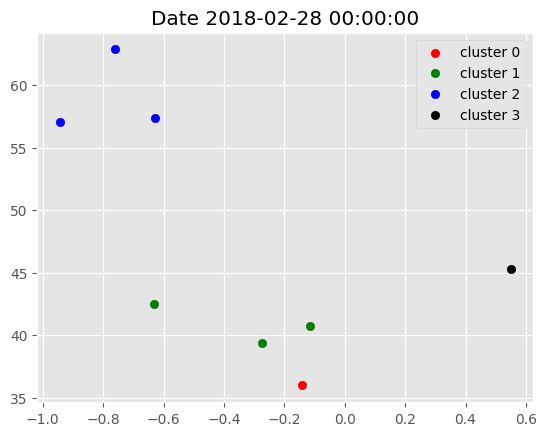

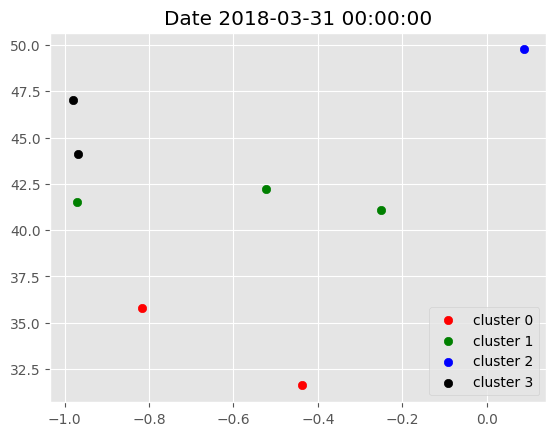

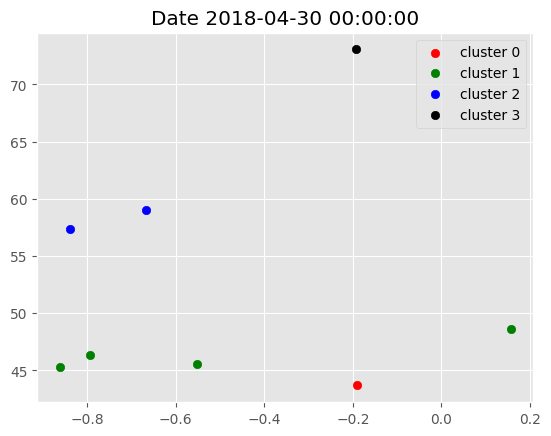

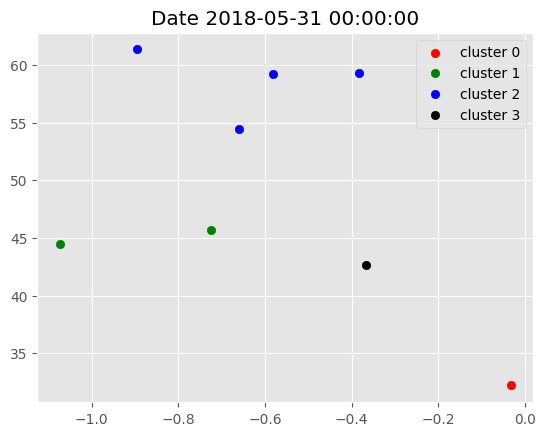

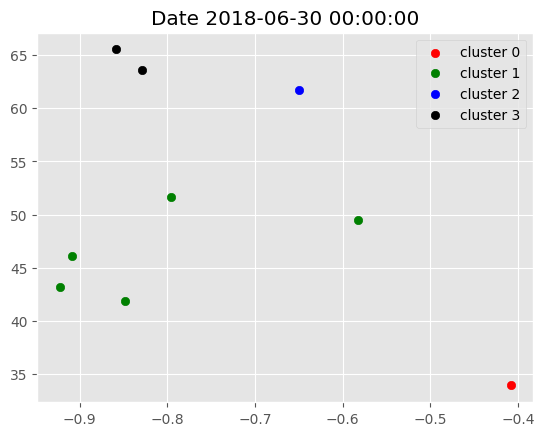

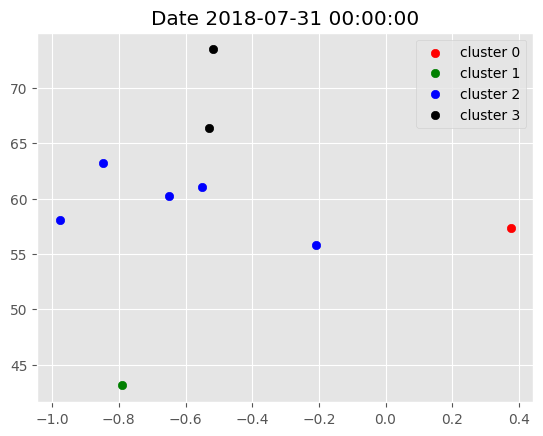

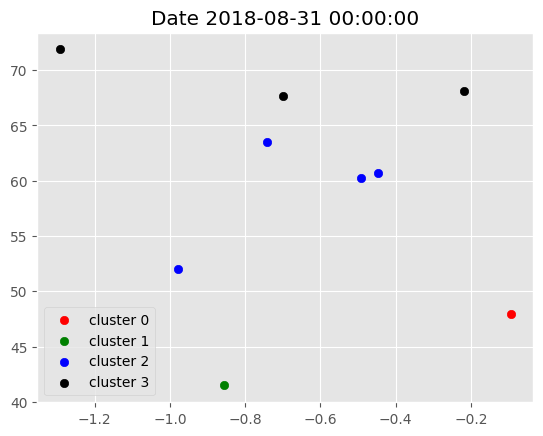

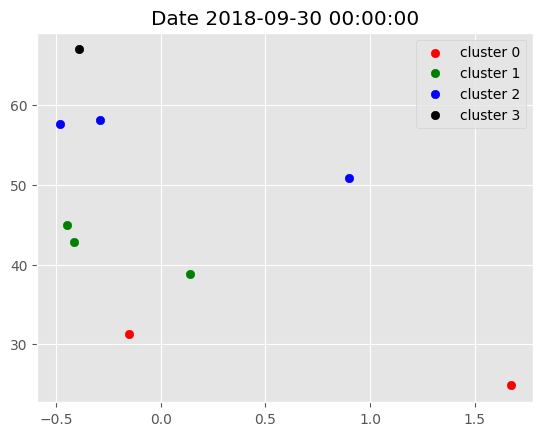

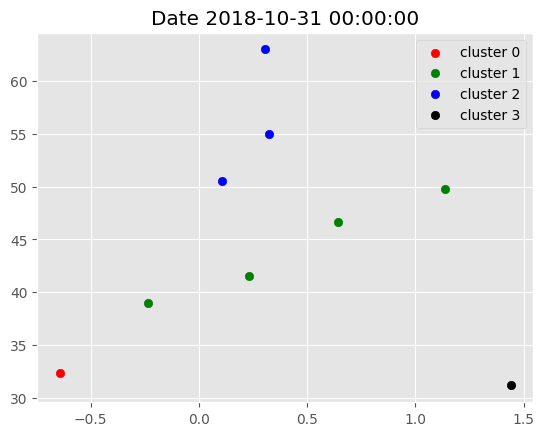

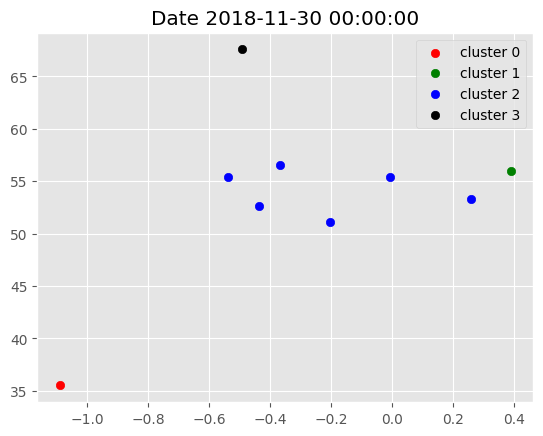

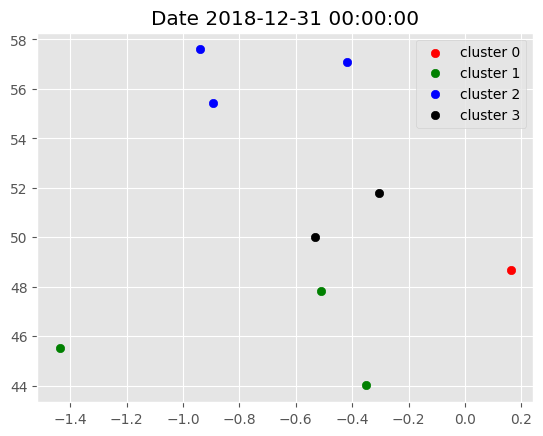

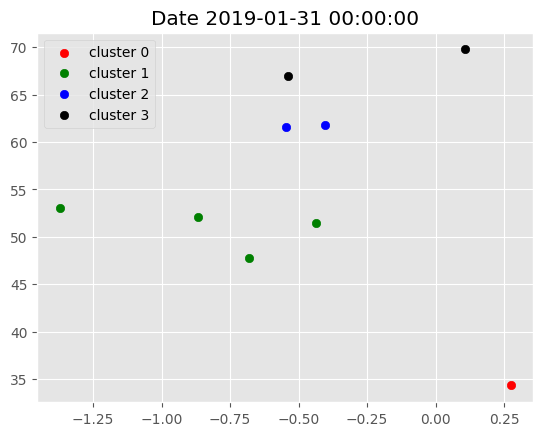

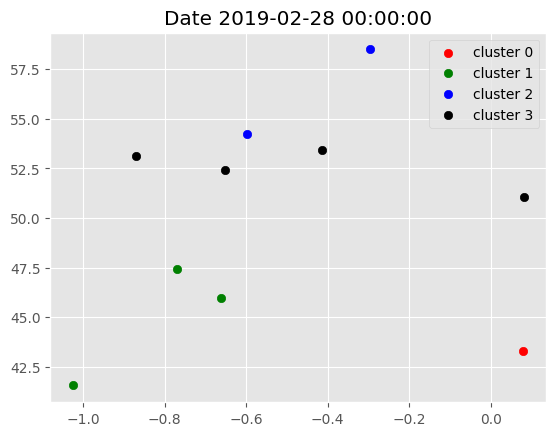

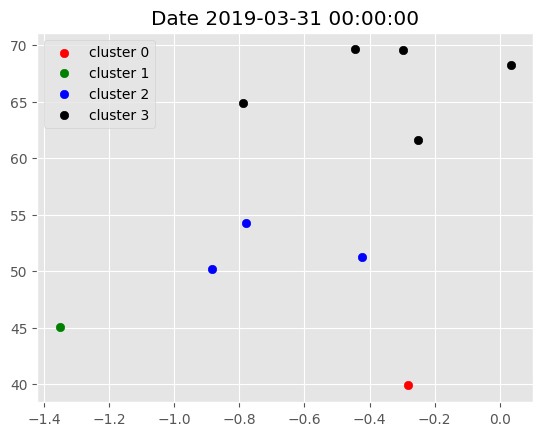

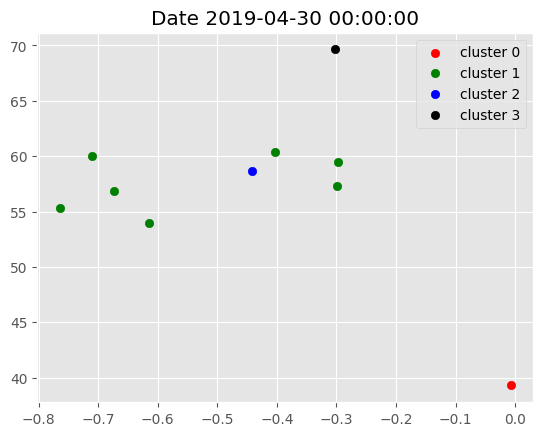

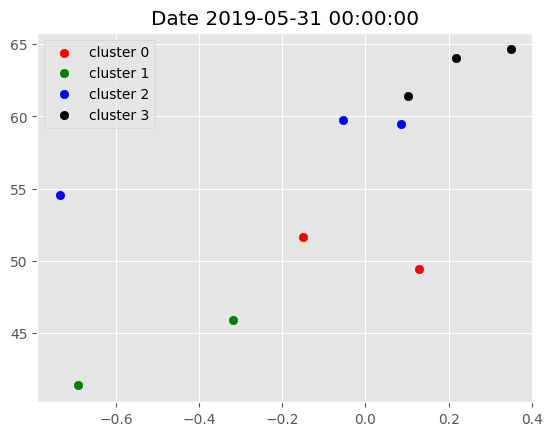

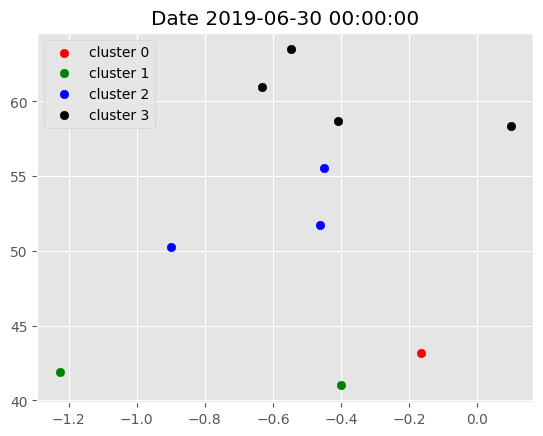

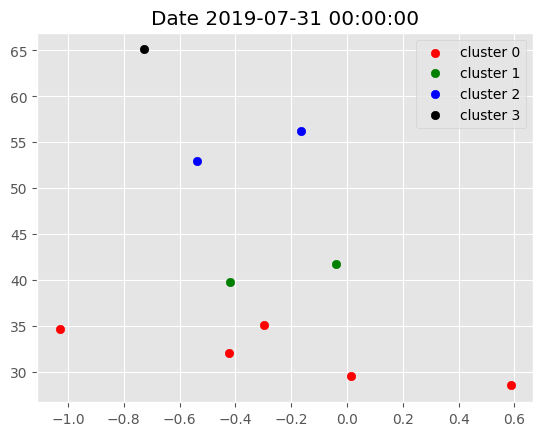

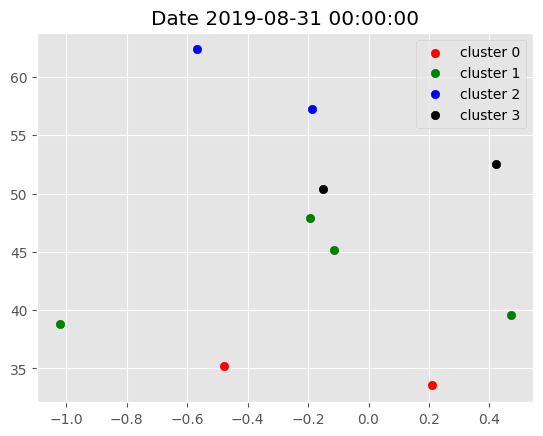

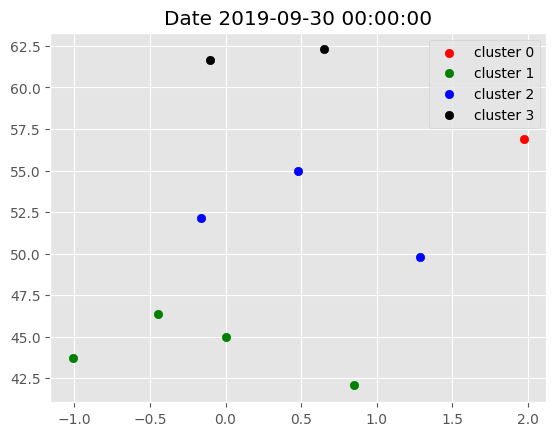

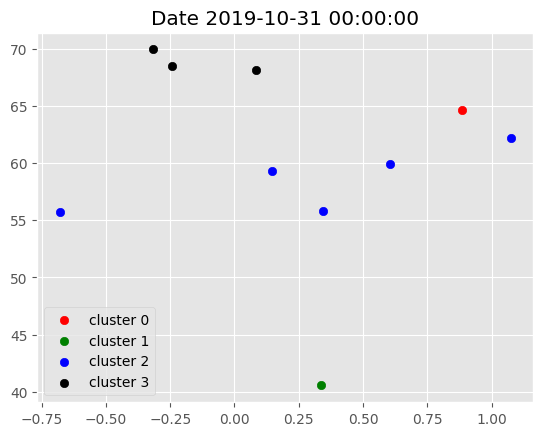

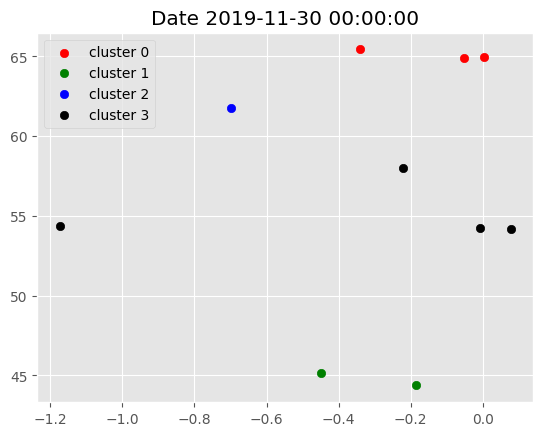

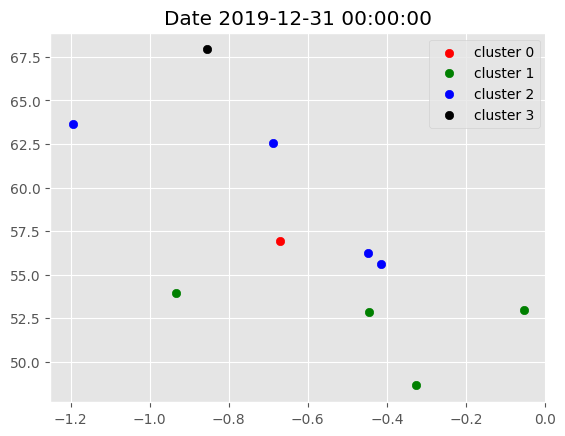

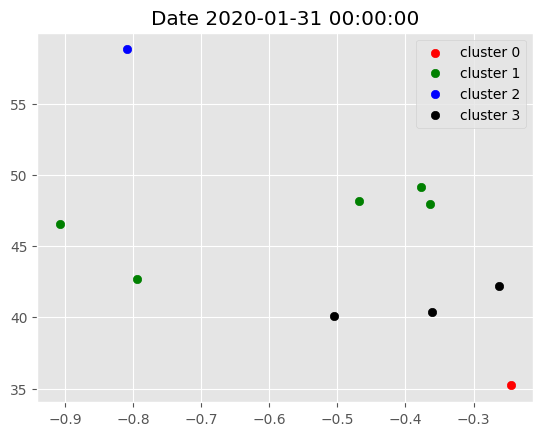

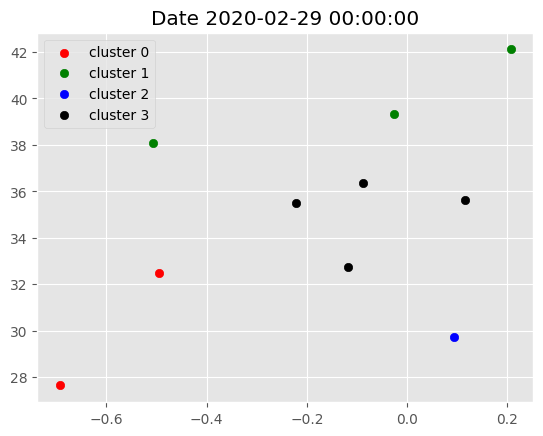

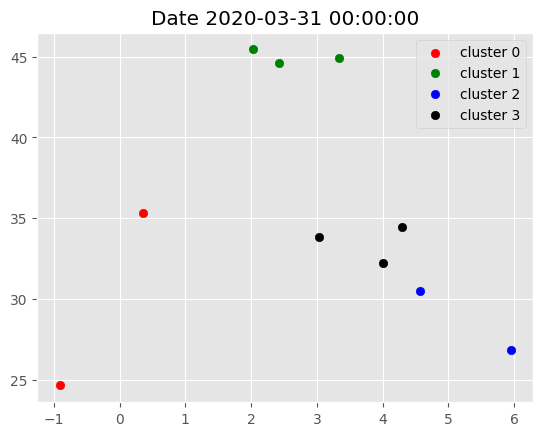

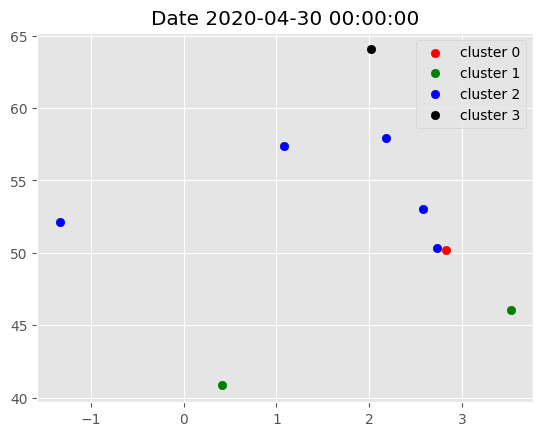

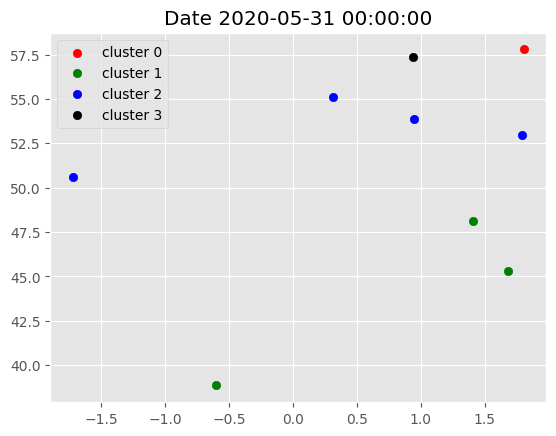

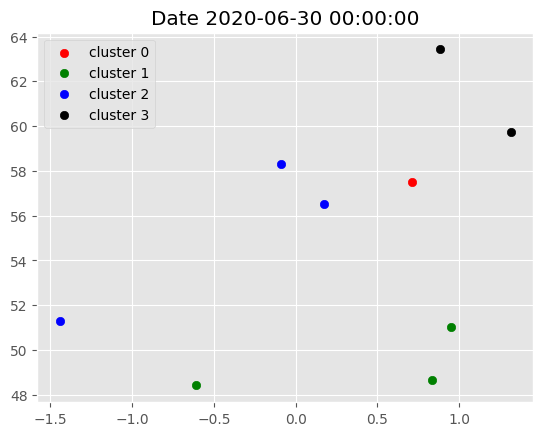

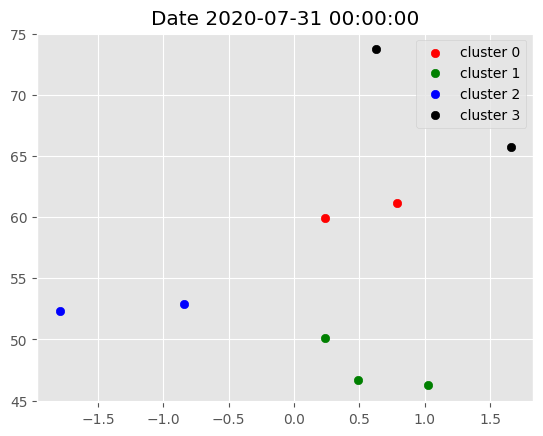

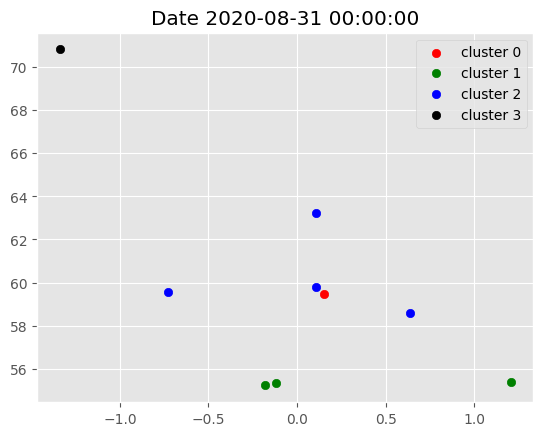

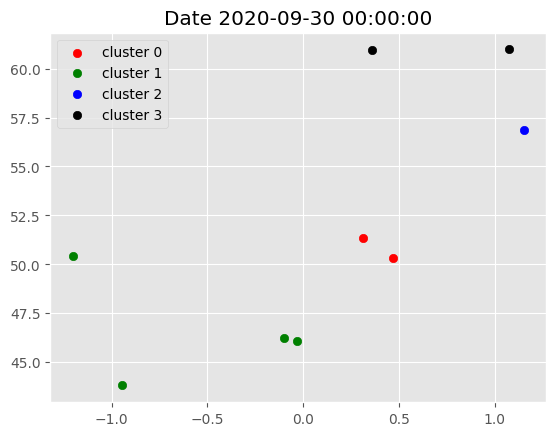

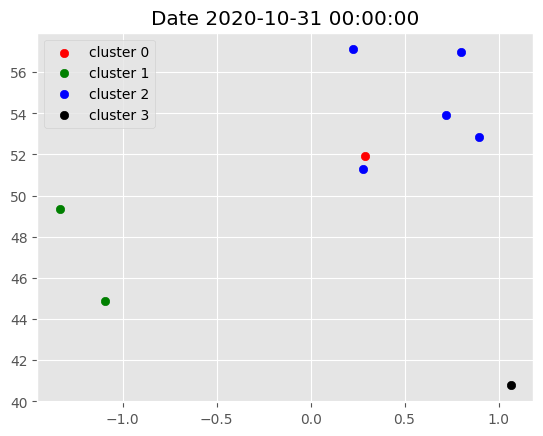

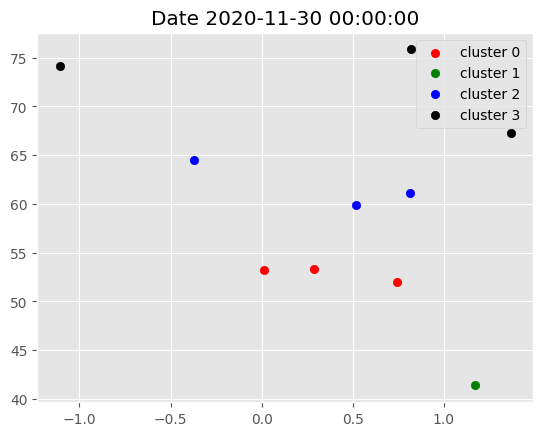

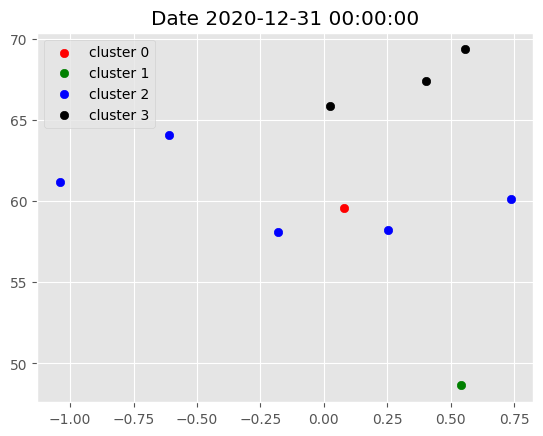

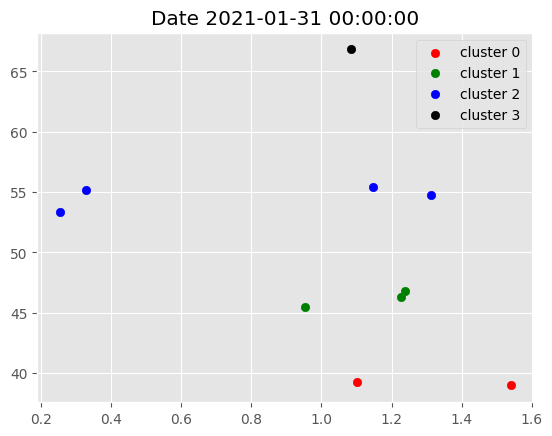

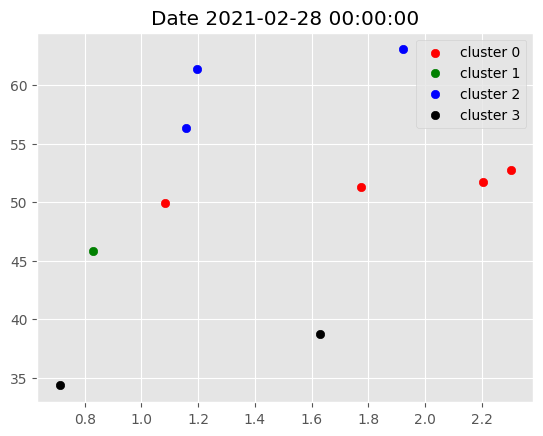

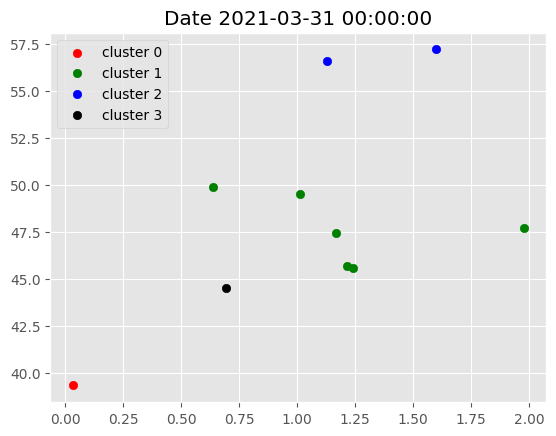

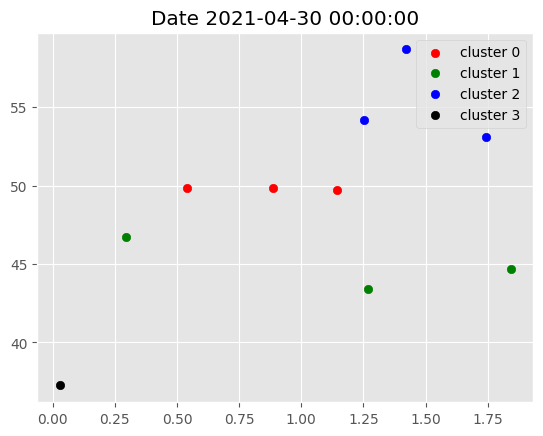

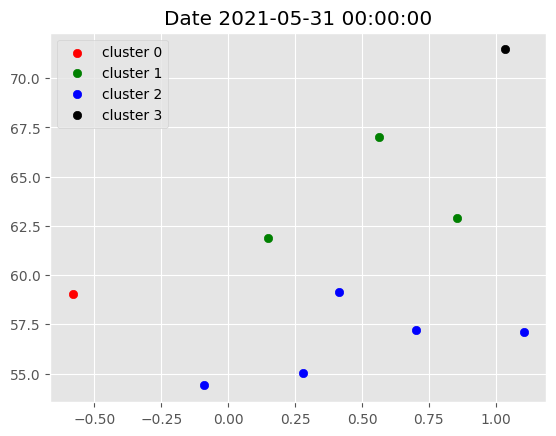

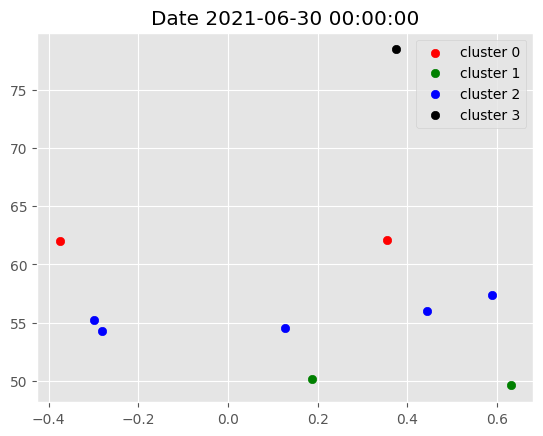

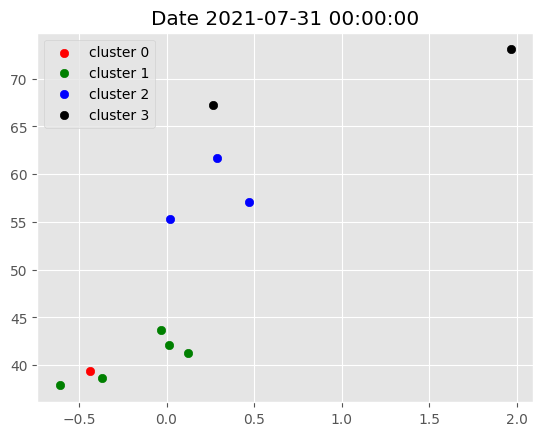

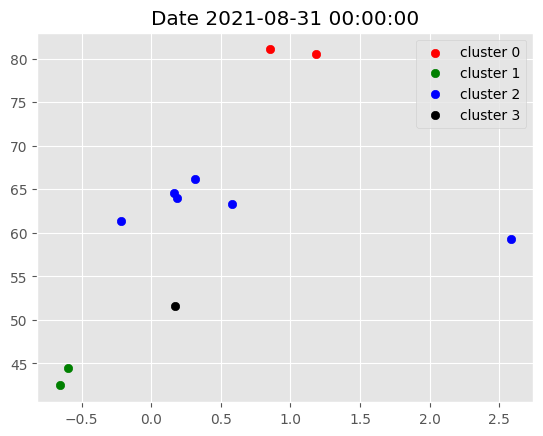

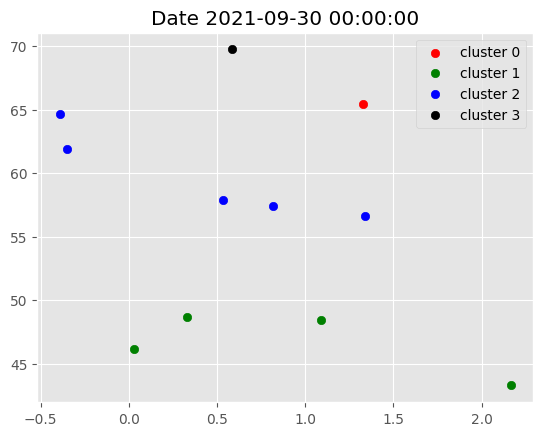

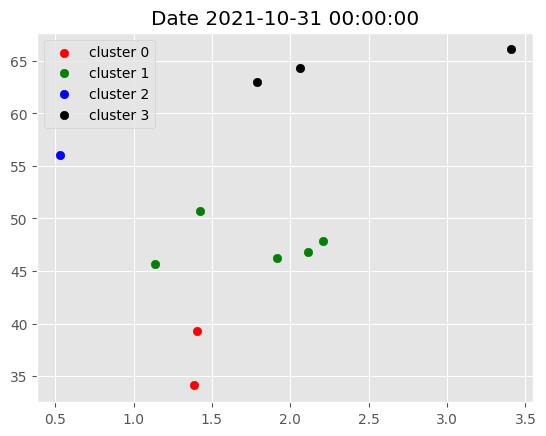

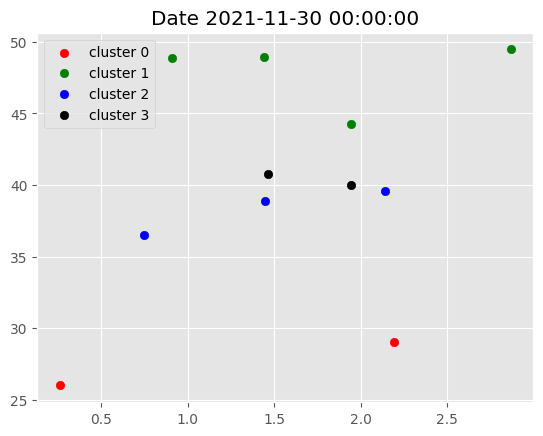

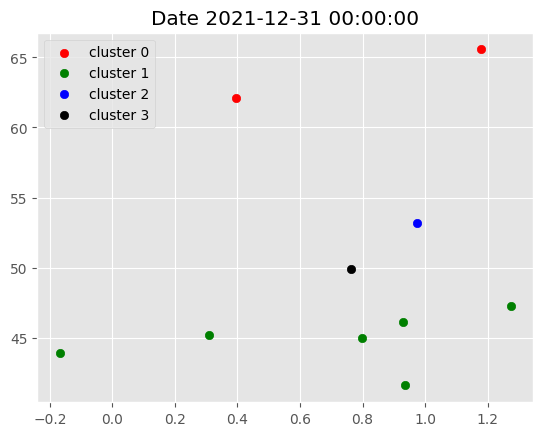

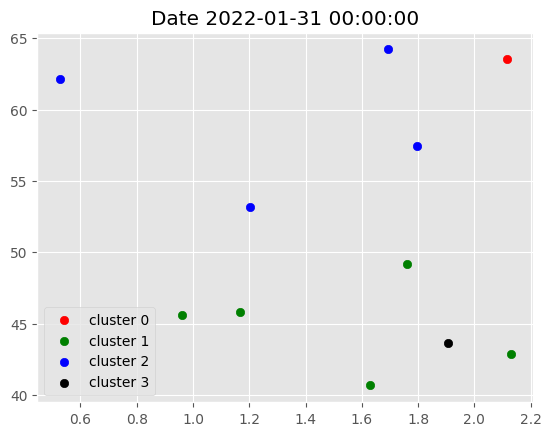

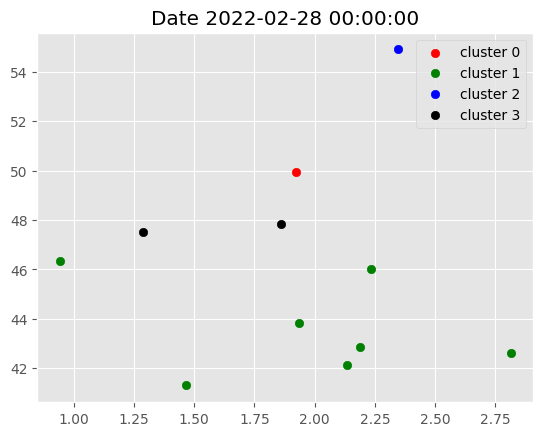

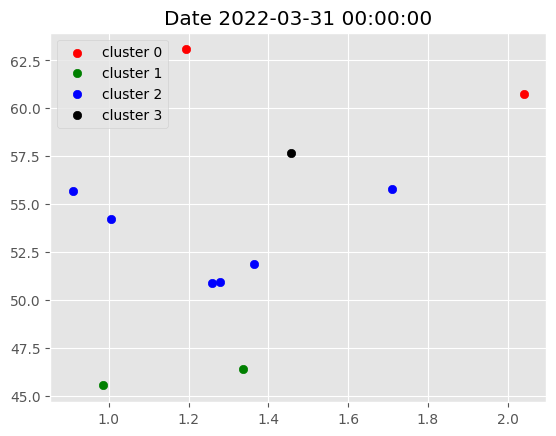

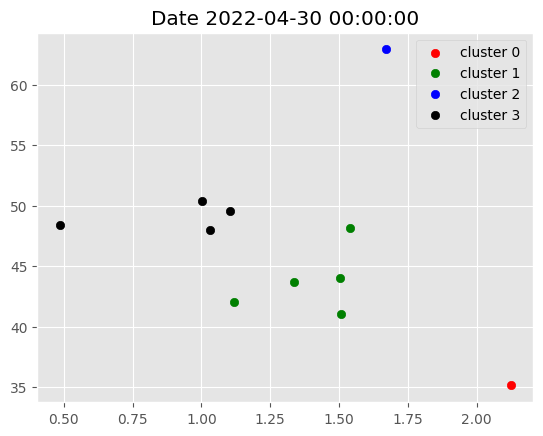

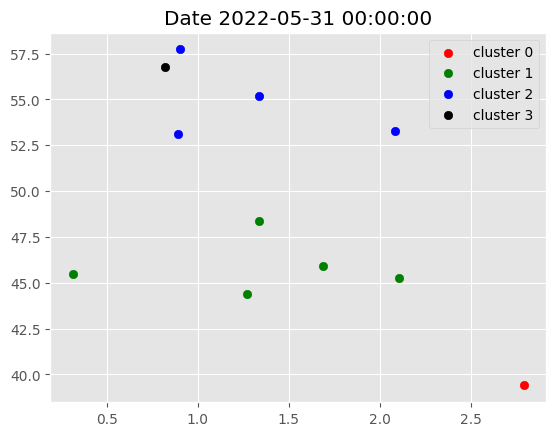

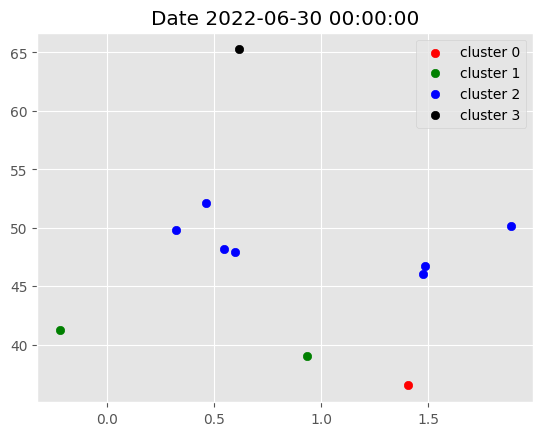

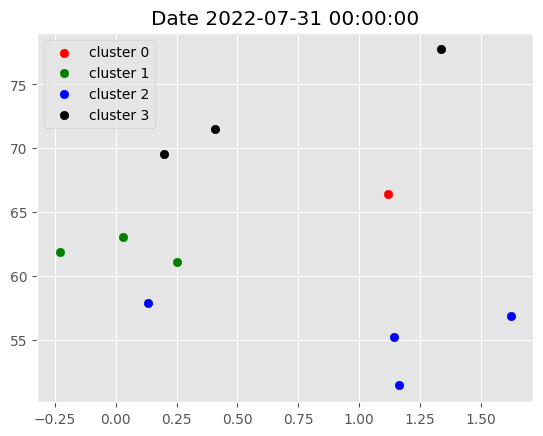

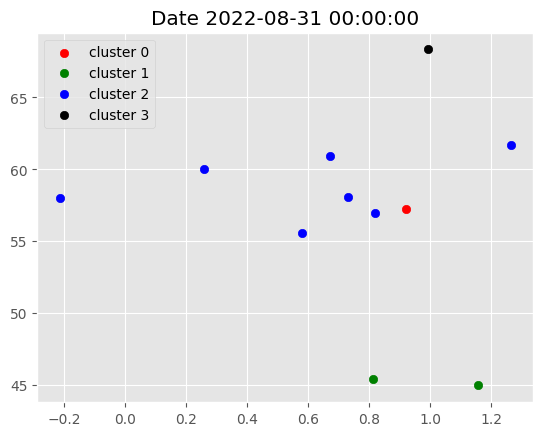

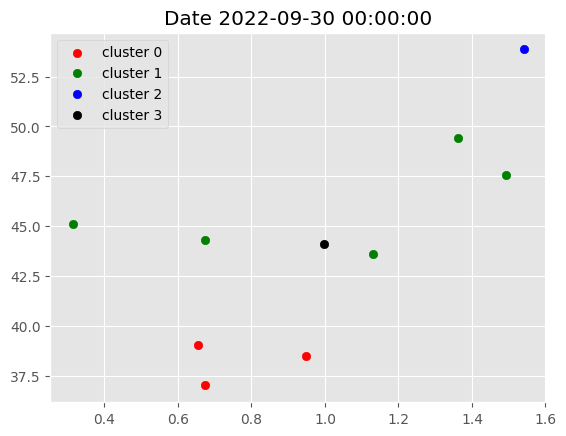

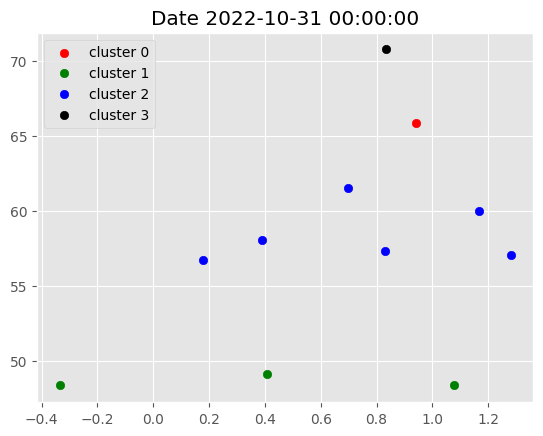

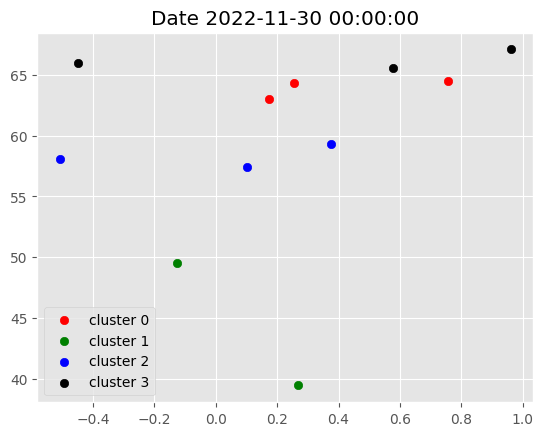

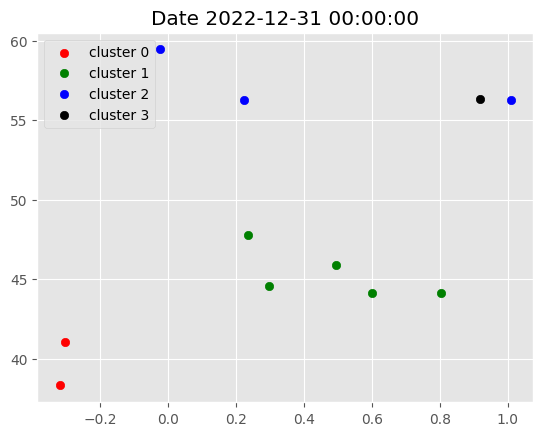

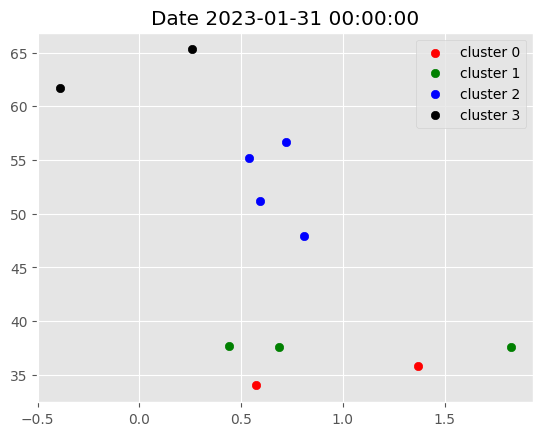

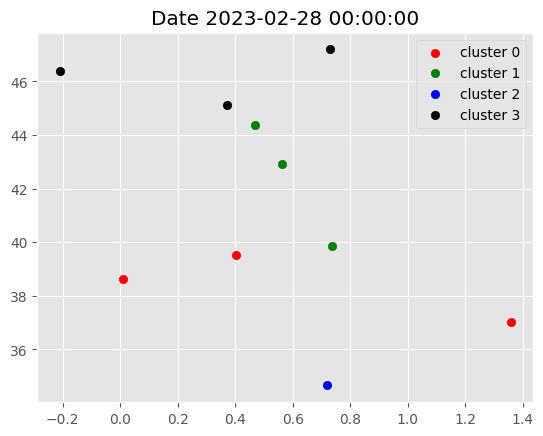

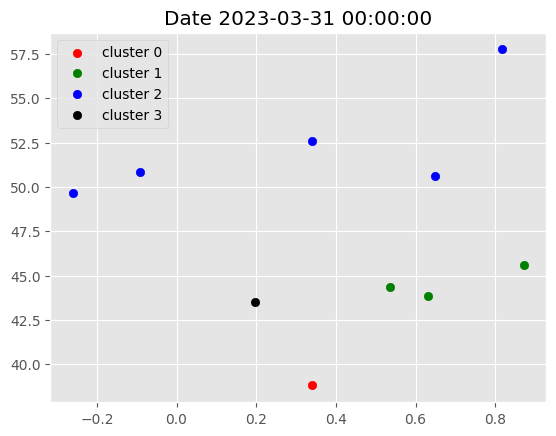

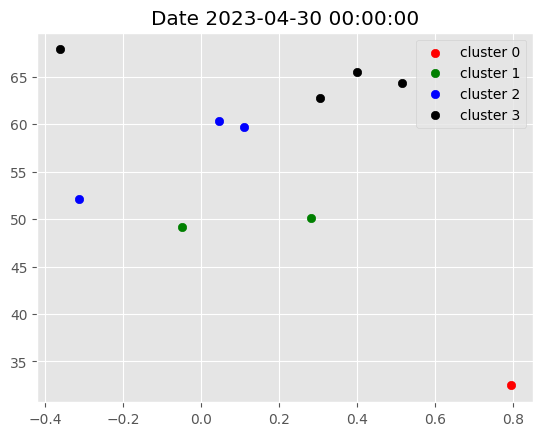

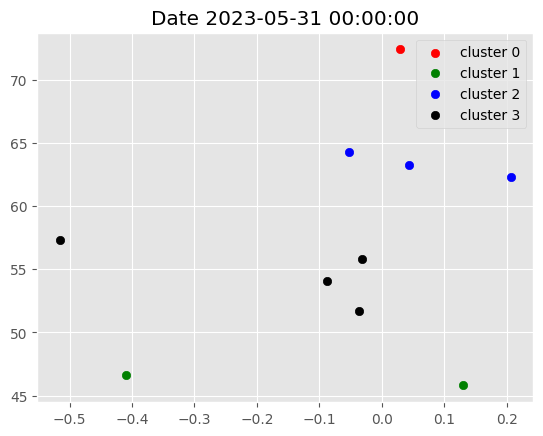

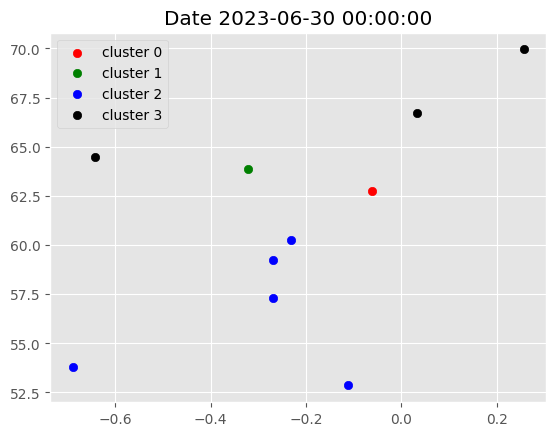

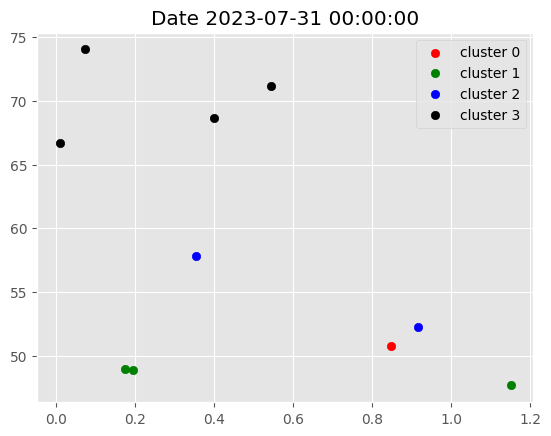

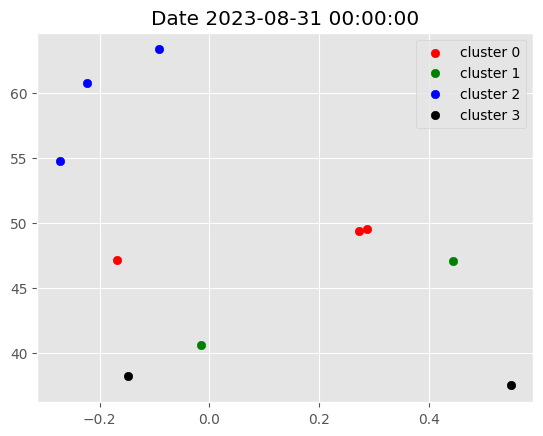

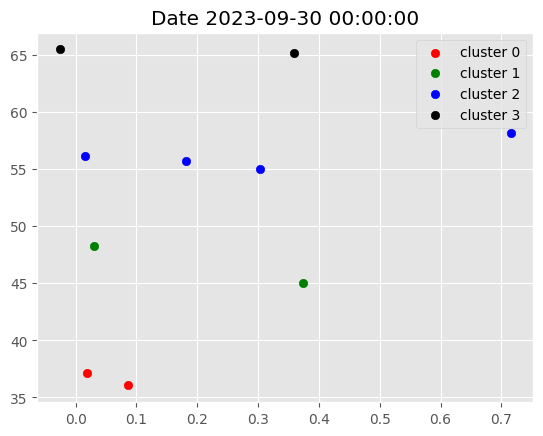

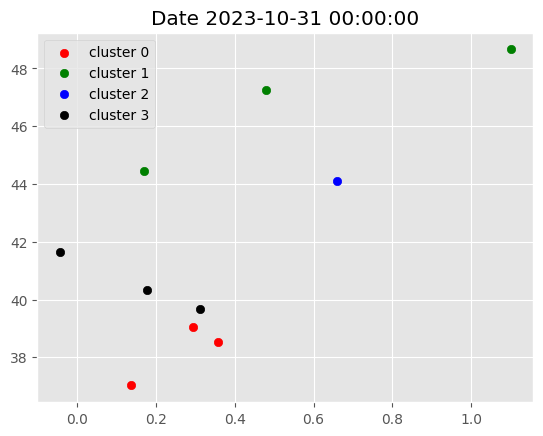

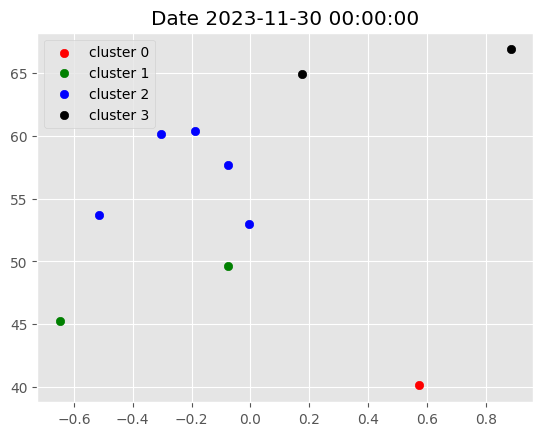

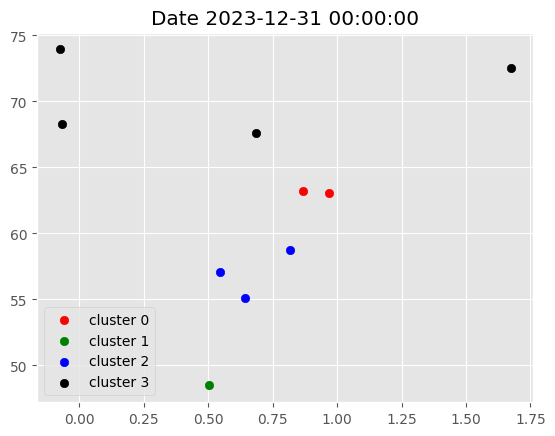

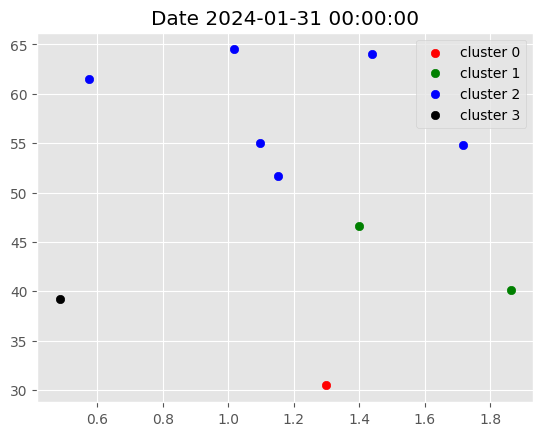

In [13]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization
First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.

In [14]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2018-03-01': ['MARUTI.NS'],
 '2018-04-01': ['INFY.NS', 'TCS.NS'],
 '2018-05-01': ['TCS.NS'],
 '2018-06-01': ['MARUTI.NS'],
 '2018-07-01': ['INFY.NS', 'TCS.NS'],
 '2018-08-01': ['RELIANCE.NS', 'SBIN.NS'],
 '2018-09-01': ['AXISBANK.NS', 'ICICIBANK.NS', 'TCS.NS'],
 '2018-10-01': ['TCS.NS'],
 '2018-11-01': ['MARUTI.NS'],
 '2018-12-01': ['HDFCBANK.NS'],
 '2019-01-01': ['AXISBANK.NS', 'RELIANCE.NS'],
 '2019-02-01': ['AXISBANK.NS', 'INFY.NS'],
 '2019-03-01': ['INFY.NS', 'RELIANCE.NS', 'TATAMOTORS.NS', 'TCS.NS'],
 '2019-04-01': ['AXISBANK.NS',
  'HDFCBANK.NS',
  'ICICIBANK.NS',
  'RELIANCE.NS',
  'SBIN.NS'],
 '2019-05-01': ['TCS.NS'],
 '2019-06-01': ['AXISBANK.NS', 'HDFCBANK.NS', 'SBIN.NS'],
 '2019-07-01': ['AXISBANK.NS', 'HDFCBANK.NS', 'ICICIBANK.NS', 'SBIN.NS'],
 '2019-08-01': ['INFY.NS'],
 '2019-09-01': ['MARUTI.NS', 'RELIANCE.NS'],
 '2019-10-01': ['HDFCBANK.NS', 'RELIANCE.NS'],
 '2019-11-01': ['RELIANCE.NS', 'TATAMOTORS.NS', 'TCS.NS'],
 '2019-12-01': ['AXISBANK.NS', 'HDFCBANK.NS', 'MARUT

Define portfolio optimization function
We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [15]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

Download Fresh Daily Prices Data only for short listed stocks.


In [16]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%%**********************]  11 of 11 completed


Adj Close                                                       \
            AXISBANK.NS BAJFINANCE.NS  HDFCBANK.NS ICICIBANK.NS      INFY.NS   
Date                                                                           
2017-02-28   499.826599   1083.915527   662.018738   242.031525   420.897095   
2017-03-01   506.485718   1052.274536   662.756897   244.440018   426.197845   
2017-03-02   499.481262   1025.768311   657.256287   244.045914   425.428650   
2017-03-03   505.992432   1023.323181   655.779968   241.681213   428.713043   
2017-03-06   511.665009   1011.292664   657.565857   242.381882   429.835571   
...                 ...           ...          ...          ...          ...   
2024-01-19  1116.550049   7319.100098  1470.650024   999.200012  1659.199951   
2024-01-22  1116.550049   7319.100098  1470.650024   999.200012  1659.199951   
2024-01-23  1089.250000   7070.700195  1427.349976  1029.050049  1642.150024   
2024-01-24  1059.150024   7055.299805  1455.900024   999.200012  1675.400024   
2024-01-25  1042.250000   7085.500000  1434.900024  1009.950012  1669.099976   

                                                                              \
               MARUTI.NS  RELIANCE.NS     SBIN.NS TATAMOTORS.NS TATASTEEL.NS   
Date                                                                           
2017-02-28   5555.929199   593.621948  255.323135    455.330872    37.896858   
2017-03-01   5553.209473   591.919922  257.741669    448.053558    39.282555   
2017-03-02   5552.412109   592.998779  253.521027    460.265503    38.835052   
2017-03-03   5523.330078   603.451416  251.387054    458.520935    38.870384   
2017-03-06   5567.515625   625.891235  255.939606    469.337219    38.681953   
...                  ...          ...         ...           ...          ...   
2024-01-19  10037.700195  2734.899902  627.750000    823.549988   134.250000   
2024-01-22  10037.700195  2734.899902  627.750000    823.549988   134.250000   
2024-01-23   9860.450195  2657.149902  605.099976    800.450012   130.100006   
2024-01-24   9988.200195  2687.750000  618.299988    810.900024   135.149994   
2024-01-25   9881.000000  2706.149902  612.750000    811.849976   133.750000   

            ...        Volume                                              \
            ... BAJFINANCE.NS HDFCBANK.NS ICICIBANK.NS  INFY.NS MARUTI.NS   
Date        ...                                                             
2017-02-28  ...       1257475     1464004     18179839  5940132    558820   
2017-03-01  ...       2045087     1740868     19983162  4282448    559896   
2017-03-02  ...       2587153     2300994     20040929  2948498    473769   
2017-03-03  ...       1185751     1246412      9256168  5401612    362057   
2017-03-06  ...       1176084     1839562     12565060  5286386    361209   
...         ...           ...         ...          ...      ...       ...   
2024-01-19  ...        830810    54800269     23271148  4522736    377018   
2024-01-22  ...             0           0            0        0         0   
2024-01-23  ...       2533297    57734701     50797448  9401255    956269   
2024-01-24  ...       2063675    43002202     34578943  8999681    459092   
2024-01-25  ...       1168349    49470926     28315035  8865304    718817   

                                                                      
           RELIANCE.NS   SBIN.NS TATAMOTORS.NS TATASTEEL.NS   TCS.NS  
Date                                                                  
2017-02-28    16665551   7941592       5722402     35716963  2354828  
2017-03-01    11253980   7656892       8367579     80993746  1130374  
2017-03-02     8336344  14220808      13667695     60064342  1544942  
2017-03-03    38907038  10120034       7085620     35244808  1013970  
2017-03-06    30793458   9515073       4036291     43594723  1400694  
...                ...       ...           ...          ...      ...  
2024-01-19     5211352  11675202       5706888     326

Calculate daily returns for each stock which could land up in our portfolio.

Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

Calculated each day portfolio return.

In [17]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2018-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-07-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-08-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-11-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-12-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-01-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-03-01, Continuing with Equal-Weights

,Strategy Return
date,
2018-03-01,0.002539
2018-03-05,-0.008869
2018-03-06,-0.020516
2018-03-07,0.007239
2018-03-08,0.005773
...,...
2024-01-18,-0.004407
2024-01-19,0.004784
2024-01-23,-0.029644


8. Visualize Portfolio returns and compare to nifty returns.


In [18]:
nft = yf.download(tickers='^NSEI',
                  start='2015-01-01',
                  end=dt.date.today())

nft_ret = np.log(nft[['Adj Close']]).diff().dropna().rename({'Adj Close':'NIFTY  50 Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(nft_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


,Strategy Return,NIFTY 50 Buy&Hold
2018-03-01,0.002539,-0.003293
2018-03-05,-0.008869,-0.009559
2018-03-06,-0.020516,-0.010637
2018-03-07,0.007239,-0.009317
2018-03-08,0.005773,0.008673
...,...,...
2024-01-18,-0.004407,-0.005098
2024-01-19,0.004784,0.007434
2024-01-23,-0.029644,-0.017900
2024-01-24,0.020577,0.010079


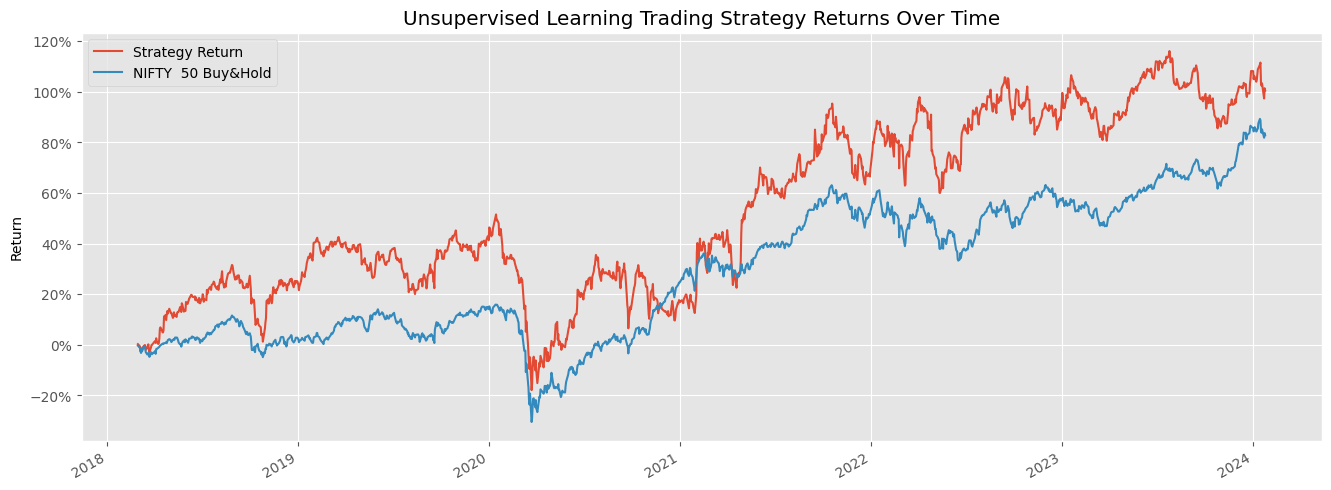

In [19]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[: end_date ].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()